## 第1步：数据探索

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 1: 加载数据文件，查看数据信息
df = pd.read_csv('broadband.csv')
df.head() # broadband 即可：0-离开，1-留存

,CUST_ID,GENDER,AGE,TENURE,CHANNEL,AUTOPAY,ARPB_3M,CALL_PARTY_CNT,DAY_MOU,AFTERNOON_MOU,NIGHT_MOU,AVG_CALL_LENGTH,BROADBAND
0,63,1,34,27,2,0,203,0,0.0,0.0,0.0,3.04,1
1,64,0,62,58,1,0,360,0,0.0,1910.0,0.0,3.30,1
2,65,1,39,55,3,0,304,0,437.2,200.3,0.0,4.92,0
3,66,1,39,55,3,0,304,0,437.2,182.8,0.0,4.92,0
4,67,1,39,55,3,0,304,0,437.2,214.5,0.0,4.92,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CUST_ID          1114 non-null   int64  
 1   GENDER           1114 non-null   int64  
 2   AGE              1114 non-null   int64  
 3   TENURE           1114 non-null   int64  
 4   CHANNEL          1114 non-null   int64  
 5   AUTOPAY          1114 non-null   int64  
 6   ARPB_3M          1114 non-null   int64  
 7   CALL_PARTY_CNT   1114 non-null   int64  
 8   DAY_MOU          1114 non-null   float64
 9   AFTERNOON_MOU    1114 non-null   float64
 10  NIGHT_MOU        1114 non-null   float64
 11  AVG_CALL_LENGTH  1114 non-null   float64
 12  BROADBAND        1114 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 113.3 KB


In [4]:
# 2: 列名全部换成小写
df.rename(str.lower, axis='columns', inplace=True)

df.sample() # 查看一个样本数据

,cust_id,gender,age,tenure,channel,autopay,arpb_3m,call_party_cnt,day_mou,afternoon_mou,night_mou,avg_call_length,broadband
450,571,1,40,13,1,0,219,0,0.0,0.0,0.0,4.96,0


In [5]:
# 3: 查看因变量 broadband 分布情况，看是否存在不平衡
from collections import Counter

print('Broadband: ', Counter(df['broadband'])) 

Broadband:  Counter({0: 908, 1: 206})


## 第2步：拆分测试集与训练集

In [6]:
y = df['broadband'] # 标签

X = df.iloc[:, 1:-1] # 客户 id 没有用，故丢弃 cust_id

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.4, random_state=123)

## 第3步：决策树建模

In [7]:
import sklearn.tree as tree

# 1. 直接使用交叉网格搜索来优化决策树模型，边训练边优化
from sklearn.model_selection import GridSearchCV

# 2. 网格搜索参数，选择最优参数
param_grid = {'criterion': ['entropy', 'gini'], # 树的深度评估指标
              'max_depth': [2, 3, 4, 5, 6, 7, 8], # 树的深度
              'min_samples_split': [4, 8, 12, 16, 20, 24, 28]} # 最小拆分的叶子样本数

In [8]:
# 3. 定义一棵树对象
clf = tree.DecisionTreeClassifier()  

# 4. 传入模型，网格搜索的参数，评估指标，cv交叉验证的次数
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc',cv=4) 

In [9]:
# 5. 训练模型
clfcv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [4, 8, 12, 16, 20, 24, 28]},
             scoring='roc_auc')

In [10]:
# 6. 使用模型来对测试集进行预测
test_result = clfcv.predict(X_test)

In [11]:
# 7. 模型评估
import sklearn.metrics as metrics

print("决策树准确度:")
print(metrics.classification_report(y_test,test_result))

决策树准确度:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       360
           1       0.72      0.42      0.53        86

    accuracy                           0.86       446
   macro avg       0.80      0.69      0.72       446
weighted avg       0.84      0.86      0.84       446



In [12]:
# 8. 决策树的AUC

print("决策树 AUC:")
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, test_result)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

决策树 AUC:
AUC = 0.6899


In [13]:
# 9. 网格搜索后的最优参数

clfcv.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 12}

In [14]:
# 10. 将最优参数代入到模型中，重新训练、预测

clf2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=4)

clf2.fit(X_train, y_train)

test_res2 = clf2.predict(X_test)

In [15]:
# 11. 绘制图形 pip3 install graphviz

import graphviz

dot_data = tree.export_graphviz(clf2, out_file=None)

graph = graphviz.Source(dot_data)

graph.render('user')

'user.pdf'

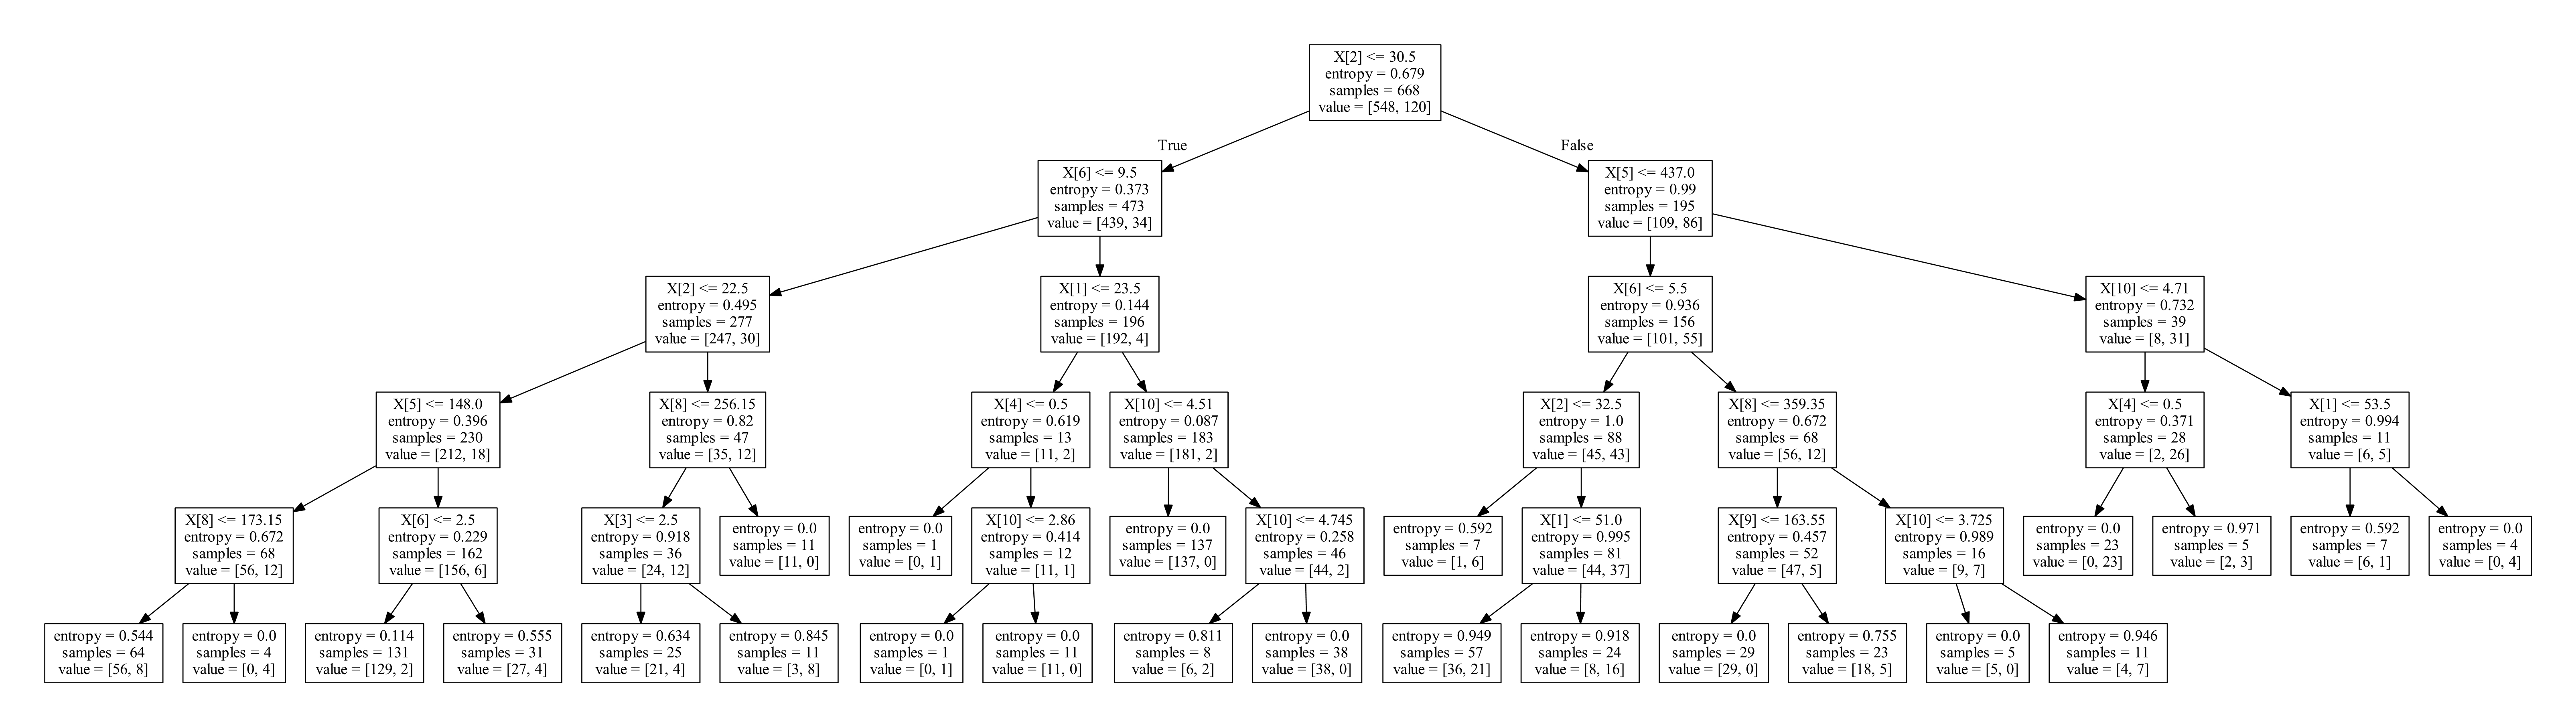

In [16]:
from PIL import Image

Image.open('user.jpg')

## 第4步：随机森林建模

In [17]:
# 1. 网格搜索

param_grid = {
    'criterion':['entropy','gini'],# 衡量标准
    'max_depth':[5, 6, 7, 8],    # 每棵决策树的深度
    'n_estimators':[11,13,15],  # 决策树个数 - 随机森林特有参数
    'max_features':[0.3,0.4,0.5], # 每棵决策树使用的变量占比 - 随机森林特有参数
    'min_samples_split':[4,8,12,16]  # 叶子的最小拆分样本量
}

In [18]:
import sklearn.ensemble as ensemble # ensemble learning: 集成学习

In [19]:
# 2. 随机森林算法

rfc = ensemble.RandomForestClassifier()

rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid,
                      scoring='roc_auc', cv=4)

rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 6, 7, 8],
                         'max_features': [0.3, 0.4, 0.5],
                         'min_samples_split': [4, 8, 12, 16],
                         'n_estimators': [11, 13, 15]},
             scoring='roc_auc')

In [20]:
# 3. 使用随机森林对测试集进行预测

predict_test = rfc_cv.predict(X_test)

print('随机森林精确度...')
print(metrics.classification_report(predict_test, y_test))

随机森林精确度...
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       403
           1       0.41      0.81      0.54        43

    accuracy                           0.87       446
   macro avg       0.69      0.84      0.73       446
weighted avg       0.92      0.87      0.89       446



In [21]:
# 4. AUC的值

print('随机森林 AUC...')
fpr_test, tpr_test, th_test = metrics.roc_curve(predict_test, y_test) # 构造 roc 曲线

print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

随机森林 AUC...
AUC = 0.8437


In [22]:
# 5. 查看最佳参数（有可能不是最优参数，仍然需要调参）

rfc_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.3,
 'min_samples_split': 4,
 'n_estimators': 15}

In [23]:
# 6. 调整决策边界，调参

param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[7, 8, 10, 12], # 前面的 5，6 也可以适当的去掉，反正已经没有用了
    'n_estimators':[11, 13, 15, 17, 19],  # 决策树个数 - 随机森林特有参数
    'max_features':[0.4, 0.5, 0.6, 0.7], # 每棵决策树使用的变量占比 - 随机森林特有参数
    'min_samples_split':[2, 3, 4, 8, 12, 16]  # 叶子的最小拆分样本量
}

# 7. 重复上述步骤，再次训练，寻找最优参数

rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid,
                      scoring='roc_auc', cv=4)

rfc_cv.fit(X_train, y_train)

# 8. 使用随机森林对测试集进行预测
predict_test = rfc_cv.predict(X_test)

print('随机森林精确度...')
print(metrics.classification_report(predict_test, y_test))

print('随机森林 AUC...')
fpr_test, tpr_test, th_test = metrics.roc_curve(predict_test, y_test) # 构造 roc 曲线

print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

随机森林精确度...
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       406
           1       0.40      0.85      0.54        40

    accuracy                           0.87       446
   macro avg       0.69      0.86      0.73       446
weighted avg       0.93      0.87      0.89       446

随机森林 AUC...
AUC = 0.8610


In [24]:
# 8. 查看最优参数

rfc_cv.best_params_ 

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 0.5,
 'min_samples_split': 3,
 'n_estimators': 17}

## 树模型参数:

-  1.criterion  gini  or  entropy

-  2.splitter  best or random 前者是在所有特征中找最好的切分点 后者是在部分特征中（数据量大的时候）

-  3.max_features  None（所有），log2，sqrt，N  特征小于50的时候一般使用所有的

-  4.max_depth  数据少或者特征少的时候可以不管这个值，如果模型样本量多，特征也多的情况下，可以尝试限制下

-  5.min_samples_split  如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

-  6.min_samples_leaf  这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝，如果样本量不大，不需要管这个值，大些如10W可是尝试下5

-  7.min_weight_fraction_leaf 这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。

-  8.max_leaf_nodes 通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制具体的值可以通过交叉验证得到。

-  9.class_weight 指定样本各类别的的权重，主要是为了防止训练集某些类别的样本过多导致训练的决策树过于偏向这些类别。这里可以自己指定各个样本的权重如果使用“balanced”，则算法会自己计算权重，样本量少的类别所对应的样本权重会高。

- 10.min_impurity_split 这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益，均方差，绝对差)小于这个阈值则该节点不再生成子节点。即为叶子节点 。
- n_estimators:要建立树的个数